# 双线性插值滤波

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from pyexcel_xls import get_data

In [2]:
def noise_gaussian(M,N,a = 0,b=1):
    R = a + b * np.random.randn(M,N)
    return R

In [3]:
def bilinear(img,m,n):  
    height,width,channels =img.shape  
    emptyImage=np.zeros((m,n,channels),np.uint8)  
    value=[0,0,0]  
    sh=m//height  
    sw=n//width  
    for i in range(m):  
        for j in range(n):  
            x = i//sh  
            y = j//sw  
            p=(i+0.0)//sh-x  
            q=(j+0.0)//sw-y  
            x=int(x)-1  
            y=int(y)-1  
            for k in range(3):  
                if x+1<m and y+1<n:  
                    value[k]=int(img[x,y][k]*(1-p)*(1-q)+img[x,y+1][k]*q*(1-p)+img[x+1,y][k]*(1-q)*p+img[x+1,y+1][k]*p*q)  
            emptyImage[i, j] = (value[0], value[1], value[2])  
    return emptyImage  
  

In [4]:
src = cv2.cvtColor(cv2.imread('../../datas/f3.jpg'),cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(src,cv2.COLOR_RGB2GRAY)

In [5]:
rows,cols = gray.shape

In [7]:
dst = bilinear(src,rows * 2,cols * 2)

Text(0.5,1,'Bilinear Interp.')

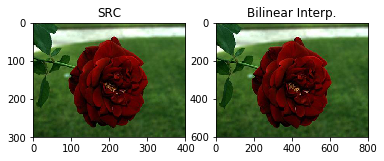

In [8]:
plt.subplot(121)
plt.imshow(src)
plt.title('SRC')
plt.subplot(122)
plt.imshow(dst)
plt.title('Bilinear Interp.')

In [10]:
# 最近邻
def neareast_neighbor(img,rows,cols):  
    height,width,channels =img.shape  
    emptyImage=np.zeros((rows,cols,channels),np.uint8)  
    sh=rows//height  
    sw=cols//width  
    for i in range(rows):  
        for j in range(cols):  
            x=int(i/sh)  
            y=int(j/sw)  
            emptyImage[i,j]=img[x,y]  
    return emptyImage  

In [11]:
dst_nn = neareast_neighbor(src,rows * 2,cols * 2)

Text(0.5,1,'Neareast Neighbor')

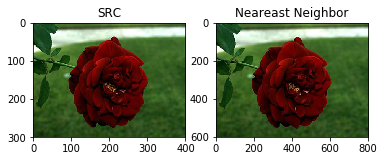

In [12]:
plt.subplot(121)
plt.imshow(src)
plt.title('SRC')
plt.subplot(122)
plt.imshow(dst)
plt.title('Neareast Neighbor')

In [16]:
def S(x):  
    x = np.abs(x)  
    if 0 <= x < 1:  
        return 1 - 2 * x * x + x * x * x  
    if 1 <= x < 2:  
        return 4 - 8 * x + 5 * x * x - x * x * x  
    else:  
        return 0  
# 双三次
def cube(img,m,n):  
    height,width,channels =img.shape  
    emptyImage=np.zeros((m,n,channels),np.uint8)  
    sh=m/height  
    sw=n/width  
    for i in range(m):  
        for j in range(n):  
            x = i/sh  
            y = j/sw  
            p=(i+0.0)/sh-x  
            q=(j+0.0)/sw-y  
            x=int(x)-2  
            y=int(y)-2  
            A = np.array([  
                [S(1 + p), S(p), S(1 - p), S(2 - p)]  
            ])  
            if x>=m-3:  
                m-1  
            if y>=n-3:  
                n-1  
            if x>=1 and x<=(m-3) and y>=1 and y<=(n-3):  
                B = np.array([  
                    [img[x-1, y-1], img[x-1, y],  
                     img[x-1, y+1],  
                     img[x-1, y+1]],  
                    [img[x, y-1], img[x, y],  
                     img[x, y+1], img[x, y+2]],  
                    [img[x+1, y-1], img[x+1, y],  
                     img[x+1, y+1], img[x+1, y+2]],  
                    [img[x+2, y-1], img[x+2, y],  
                     img[x+2, y+1], img[x+2, y+1]],  
  
                    ])  
                C = np.array([  
                    [S(1 + q)],  
                    [S(q)],  
                    [S(1 - q)],  
                    [S(2 - q)]  
                ])  
                blue = np.dot(np.dot(A, B[:, :, 0]), C)[0, 0]  
                green = np.dot(np.dot(A, B[:, :, 1]), C)[0, 0]  
                red = np.dot(np.dot(A, B[:, :, 2]), C)[0, 0]  
  
                # ajust the value to be in [0,255]  
                def adjust(value):  
                    if value > 255:  
                        value = 255  
                    elif value < 0:  
                        value = 0  
                    return value  
  
                blue = adjust(blue)  
                green = adjust(green)  
                red = adjust(red)  
                emptyImage[i, j] = np.array([blue, green, red], dtype=np.uint8)  
  
  
    return emptyImage  

In [17]:
dst_cube = cube(src,rows * 2,cols * 2)

Text(0.5,1,'Cube')

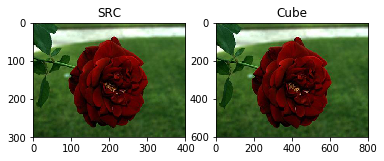

In [19]:
plt.subplot(121)
plt.imshow(src)
plt.title('SRC')
plt.subplot(122)
plt.imshow(dst)
plt.title('Cube')

In [28]:
def bilinear_filter_interp(A,filter_coef):
    m,n = A.shape[0],A.shape[1]
    A_col = cv2.filter2D(A,-1,filter_coef)
    # 列插值
    A1 = np.column_stack([A[:,0],A_col[:,0]])
    for i in range(1,n):
        A1 = np.column_stack([A1,A[:,i],A_col[:,i]])
    A_rows = cv2.filter2D(A1.T,-1,filter_coef).T
    A_interp_pic = np.row_stack([A1[0,:].T,A_rows[0,:]])
    for i in range(1,m):
        A_interp_pic = np.row_stack([A_interp_pic,A1[i,:],A_rows[i,:]])
    return A_interp_pic
    

In [29]:
filter_coef = np.array([0.5,0.5])
dst_bil = bilinear_filter_interp(gray,filter_coef)

In [30]:
print(dst_bil.shape)

(600, 800)


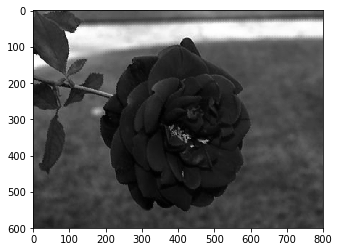

In [31]:
plt.imshow(dst_bil,'gray')